## 11. Statistics Analysis
- Pair t-test
- Fisher Exact Test
- Survival Analysis : Log Rank Test
- Kaplan Meier Curves
- Data Comparison (proc compare)

In [1]:
## import python stat packages
from scipy import stats
import pandas as pd
import numpy as np
import xport
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('seaborn-whitegrid')
import warnings
warnings.filterwarnings('ignore')

### Pair t-test
Compare Days to Event between Placebo and Study Drug

In [2]:
df_tteos = pd.read_sas('./data/raw/adtteos.sas7bdat', format='sas7bdat', encoding='utf-8')

In [3]:
## Treatment Group Descriptive Analysis
df_tteos.groupby(['TRTP'])['AVAL'].describe()

,count,mean,std,min,25%,50%,75%,max
TRTP,,,,,,,,
Control,148.0,45.729730,34.319546,1.0,10.75,40.5,84.0,96.0
Study Drug,152.0,45.513158,33.485588,1.0,13.00,45.0,83.0,92.0


Text(0, 0.5, 'Density')

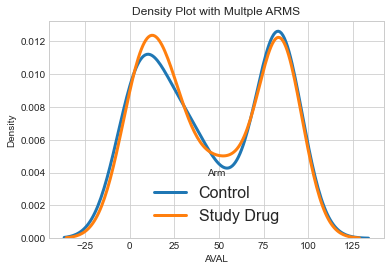

In [4]:
# List of five airlines to plot
arms = ['Control', 'Study Drug']

# Iterate through the five airlines
for arm in arms:
    # Subset to the airline
    subset = df_tteos[df_tteos['TRTP'] == arm]
    
    # Draw the density plot
    sns.distplot(subset['AVAL'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = arm)
    
# Plot formatting
plt.legend(prop={'size': 16}, title = 'Arm')
plt.title('Density Plot with Multple ARMS')
plt.xlabel('AVAL')
plt.ylabel('Density')

In [5]:
## Data preparation for t-test
Control_val = df_tteos[df_tteos['TRTP']=='Control']['AVAL'] # Control Group AVAL
StudyDrug_val = df_tteos[df_tteos['TRTP']=='Study Drug']['AVAL'] # Study Drug Group AVAL
print(Control_val.head())
print(StudyDrug_val.head())

0      1.0
1     83.0
5     62.0
7      3.0
10    85.0
Name: AVAL, dtype: float64
2    84.0
3     9.0
4    51.0
6    69.0
8     5.0
Name: AVAL, dtype: float64


In [6]:
## pair t-test
stats.ttest_ind(Control_val, StudyDrug_val)

Ttest_indResult(statistic=0.0553223058850432, pvalue=0.9559187636178077)

### Fisher Exact Test
How many subject have discontinued between Placebo and Study Drug ('Xanomeline High Dose', 'Xanomeline Low Dose')

In [7]:
## Read SAS datasets
with open('./data/raw/adsl.xpt', 'rb') as f: 
    _xport_adsl = xport.to_columns(f)
    df_adsl = pd.DataFrame(_xport_adsl) 
    

In [8]:
df_adsl.head()

,USUBJID,STUDYID,DOMAIN,SITEID,SITEGRP,SUBJID,VISIT1DT,RANDDT,TRTSTDT,RFSTDTC,...,EDUCLVL,HEIGHTBL,MMSETOT,WEIGHTBL,SAFETY,ITT,EFFICACY,COMPLT24,COMPLT16,COMPLT8
0,01-701-1015,CDISCPILOT01,ADSL,701,701,1015,19718.0,19725.0,19725.0,2014-01-02,...,16.0,147.3,23.0,54.4,Y,Y,Y,Y,Y,Y
1,01-701-1023,CDISCPILOT01,ADSL,701,701,1023,19196.0,19210.0,19210.0,2012-08-05,...,14.0,162.6,23.0,80.3,Y,Y,Y,N,N,N
2,01-701-1028,CDISCPILOT01,ADSL,701,701,1028,19550.0,19558.0,19558.0,2013-07-19,...,16.0,177.8,23.0,99.3,Y,Y,Y,Y,Y,Y
3,01-701-1033,CDISCPILOT01,ADSL,701,701,1033,19792.0,19800.0,19800.0,2014-03-18,...,12.0,175.3,23.0,88.5,Y,Y,Y,N,N,N
4,01-701-1034,CDISCPILOT01,ADSL,701,701,1034,19898.0,19905.0,19905.0,2014-07-01,...,9.0,154.9,21.0,62.6,Y,Y,Y,Y,Y,Y


In [9]:
## Data Preparation for Fisher Exact Tests - Xanomeline and Placebo
df_adsl['TRTP1'] = df_adsl.TRTP.replace(['Xanomeline High Dose', 'Xanomeline Low Dose'],['Xanomeline','Xanomeline']) ## conversion
count = df_adsl.groupby(['TRTP1','DISCONT'])['SUBJID'].count()  ## occurence count of treatment and discontinuation
print("Catoegorical results of trtment and discontinuation: \n", count)
print(type(count))

Catoegorical results of trtment and discontinuation: 
 TRTP1       DISCONT
Placebo                 58
            Y           28
Xanomeline              52
            Y          116
Name: SUBJID, dtype: int64
<class 'pandas.core.series.Series'>


In [10]:
df_adsl[['TRTP1','DISCONT']].head()

,TRTP1,DISCONT
0,Placebo,
1,Placebo,Y
2,Xanomeline,
3,Xanomeline,Y
4,Xanomeline,


In [11]:
count.values.reshape(2,2) ## convert values of Series to numpy with 2 by 2 shape

array([[ 58,  28],
       [ 52, 116]], dtype=int64)

In [12]:
## Fisher Exact Test
oddsratio, pvalue = stats.fisher_exact(count.values.reshape(2,2)) ## 2 by 2 array is an input.  
print("Odds Ratio : \n", oddsratio)
print("P value: \n", pvalue)

Odds Ratio : 
 4.6208791208791204
P value: 
 3.189001514988957e-08


### Survival analysis - log rank test

In [13]:
## import lifeline logrank test function
from lifelines.statistics import logrank_test ## need to install lifelines(pip install lifelines)

In [14]:
df_tteos.groupby(['TRTP']).count()

,SUBJID,SITEID,FASFL,SAFFL,TRTPN,PARAM,PARAMCD,PARAMTYP,AVISIT,AVISITN,AVAL,STARTDT,ADT,ADTF,CNSR,EVNTDESC
TRTP,,,,,,,,,,,,,,,,
Control,148,148,148,148,148,148,148,148,148,148,148,148,148,14,148,148
Study Drug,152,152,152,152,152,152,152,152,152,152,152,152,152,21,152,152


In [15]:
tte_control = df_tteos[df_tteos['TRTP']=='Control'][['TRTP','AVAL','CNSR']]
print("Treatment data occurrence - Control: \n", tte_control.groupby(['TRTP']).count())

tte_sd = df_tteos[df_tteos['TRTP']=='Study Drug'][['TRTP','AVAL','CNSR']]
print("Treatment data occurrence - Study Drug: \n", tte_sd.groupby(['TRTP']).count())

Treatment data occurrence - Control: 
          AVAL  CNSR
TRTP               
Control   148   148
Treatment data occurrence - Study Drug: 
             AVAL  CNSR
TRTP                  
Study Drug   152   152


In [16]:
results = logrank_test(tte_control['AVAL'], tte_sd['AVAL'], event_observed_A=tte_control['CNSR'], event_observed_B=tte_sd['AVAL'], alpha=.95)

results.print_summary()
print("p-value of log rank test on adtteos : ", results.p_value)

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          57.92 <0.005     45.06

p-value of log rank test on adtteos :  2.7255238338147342e-14


### Survival analysis - Kaplan Meier Curves

Text(0.5, 1.0, 'Kaplan Meier curves between Control and Study Drug')

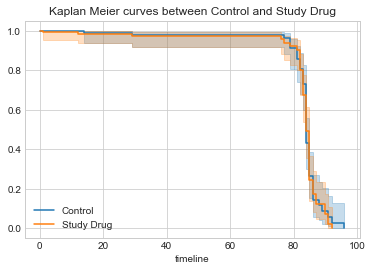

In [22]:
### Import lifelines and Kaplan Meier Curves 
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt ## import plotting library
%matplotlib inline 

kmf = KaplanMeierFitter()

ax = plt.subplot(111)

kmf.fit(tte_control.AVAL, event_observed=tte_control.CNSR, label="Control")
kmf.plot(ax=ax)
kmf.fit(tte_sd.AVAL, event_observed=tte_sd.CNSR, label="Study Drug")
kmf.plot(ax=ax)

plt.title('Kaplan Meier curves between Control and Study Drug')

## Compare two datasets just like SAS proc compare

In [23]:
## Create the first dataset
raw1 = {'subjid': ['01-001', '01-002', '01-003', '02-001'],
      'sysbp': [154, 152, 148, 149],
      'diabp': [44, 48, 47, 50],
      'weight': [90.5, 83, 78, 77]} ## dicionary
df1 = pd.DataFrame(raw1)
print(df1)

## Create the first dataset
raw1 = {'subjid': ['01-001', '01-002', '01-003', '02-001'],
      'sysbp': [154, 152, 150, 149],
      'diabp': [44, 50, 47, 50],
      'weight': [90.5, 83, 78, 77]} ## dicionary
df2 = pd.DataFrame(raw1)
print(df2)

   subjid  sysbp  diabp  weight
0  01-001    154     44    90.5
1  01-002    152     48    83.0
2  01-003    148     47    78.0
3  02-001    149     50    77.0
   subjid  sysbp  diabp  weight
0  01-001    154     44    90.5
1  01-002    152     50    83.0
2  01-003    150     47    78.0
3  02-001    149     50    77.0


In [24]:
import datacompy

In [25]:
## comparison 
compare = datacompy.Compare(df1, df2, join_columns='subjid')
print(compare.report())

DataComPy Comparison
--------------------

DataFrame Summary
-----------------

  DataFrame  Columns  Rows
0       df1        4     4
1       df2        4     4

Column Summary
--------------

Number of columns in common: 4
Number of columns in df1 but not in df2: 0
Number of columns in df2 but not in df1: 0

Row Summary
-----------

Matched on: subjid
Any duplicates on match values: No
Absolute Tolerance: 0
Relative Tolerance: 0
Number of rows in common: 4
Number of rows in df1 but not in df2: 0
Number of rows in df2 but not in df1: 0

Number of rows with some compared columns unequal: 2
Number of rows with all compared columns equal: 2

Column Comparison
-----------------

Number of columns compared with some values unequal: 2
Number of columns compared with all values equal: 2
Total number of values which compare unequal: 2

Columns with Unequal Values or Types
------------------------------------

  Column df1 dtype df2 dtype  # Unequal  Max Diff  # Null Diff
0  diabp     int64    